In [0]:
import numpy as np
from scipy.misc import imread, imresize 
from glob import glob # helps find files in a folder
import os # to navigate thru the filesystem
from google.colab import drive # to connect to drive 
import matplotlib.pyplot as plt # need to plot images 
import os, sys
!pip3 install -q tflearn
import tflearn 
from tflearn.layers.core import input_data
from tflearn.layers.conv import global_avg_pool
from tflearn.layers.core import fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.activations import relu # rectified linear activation function
from tflearn.layers.normalization import batch_normalization as bn
from tflearn.layers.estimator import regression # trainer for the network



In [2]:
# next step, connect to the drive 
drive.mount('/content/drive') # mounts drive to colabratory 
# always the same 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def residual_block(incoming, n_filters, filter_size, n_blocks, stride=1):
  
  for block in range(n_blocks):
    n, h, w, c = incoming.get_shape().as_list() # get the shape of input
    
    if block > 0 and stride > 1:
      stride = 1
  
    # convolution 1
    conv1 = conv_2d(incoming, n_filters, filter_size, activation='linear', strides=stride)
    conv1_norm = relu(bn(conv1))
  
    # convolution 2
    conv2 = conv_2d(conv1_norm, n_filters, filter_size, activation='linear', strides=1)
    conv2_norm = bn(conv2)
    
    if stride > 1:
      incoming = max_pool_2d(incoming, 3, stride)
    
    if c != n_filters:
      incoming = conv_2d(incoming, n_filters, 1, activation='linear', strides=1, bias=False)
  
    # elementwise addition between conv2_norm and input
    incoming = incoming + conv2_norm
  
    # relu on addition
    incoming = relu(incoming)
    
  return incoming

In [0]:
os.chdir('drive/My Drive/DeepLearningFall2018/StrokeData') # navigate thru filesystem  

In [5]:
os.listdir() # list all files and folders in this location 
# i.e. "bread" and "moldy bread"

['breaststroke frames combined',
 'freestyle frames combined',
 'breaststroke removed',
 'freestyle removed',
 'run1_swimstroke_ResNet.data-00000-of-00001',
 'run1_swimstroke_ResNet.index',
 'checkpoint',
 'run1_swimstroke_ResNet.meta']

In [0]:
os.chdir('breaststroke frames combined')

In [0]:
# create function called image_loader to take in the images all in one size that you specify 
def image_loader(img_size): 
  img_names = glob('*') # get all filenames in this location 
  imgs = np.zeros([len(img_names), img_size, img_size, 3]) # length (how many images u have) x height x width x 3 color channels 
  
  for indx, img_name in enumerate(img_names): # indx is like epoch but for the loop, so it's how many times u go through all
    img = imread(img_name) # read in the image 
    
    # if img is not correct size, resize it 
    if img.shape[0] != img_size or img.shape[1] != img_size:
      img = imresize(img, [img_size, img_size])
      
    imgs[indx, ...] = img # add that image to empty tensor 
    
  return imgs 

In [8]:
# call the function to load in the images in this directory 
breaststroke_images = image_loader(150) # size of 150

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


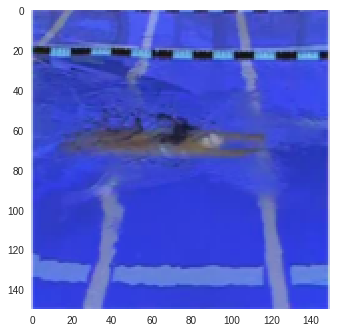

In [9]:
plt.imshow(breaststroke_images[0, :, :, ::-1]) # show first image as a check that everything loaded in properly 
# the ::-1 is switching the colors around so it looks normal when we plot the image, does not matter to the network tho
plt.grid(False)

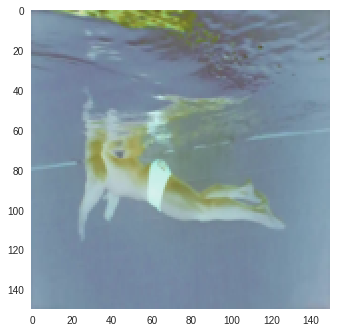

In [10]:
# also plottig the last image as a double check
plt.imshow(breaststroke_images[-1, :, :, ::-1]) # the -1 means the last one in a list 
plt.grid(False)

In [0]:
# so now we have loaded in the breaststroke, so now we need to load in the freestle
os.chdir('..') # this means go back to the folder before the one we are in rn
os.chdir('freestyle frames combined') # go into the bread folder

In [12]:
# load in the freestyle images
freestyle_images = image_loader(150) # sizes we train on are around 200-250 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [13]:
freestyle_images.shape

(801, 150, 150, 3)

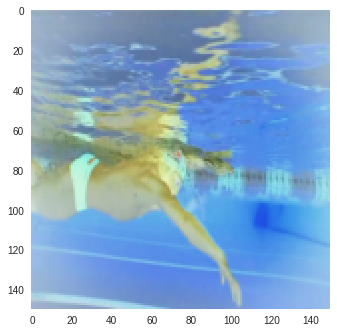

In [14]:
plt.imshow(freestyle_images[0, :, :, ::-1]) # show first image in dataset
plt.grid(False)

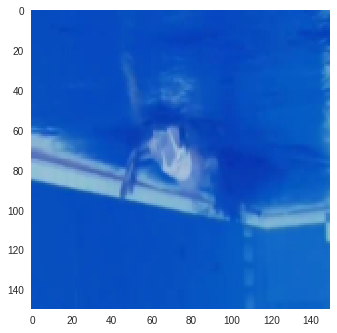

In [15]:
plt.imshow(freestyle_images[-1, :, :, ::-1]) # show last image in bread dataset
plt.grid(False)

In [16]:
freestyle_images.shape

(801, 150, 150, 3)

In [17]:
breaststroke_images.shape 

(911, 150, 150, 3)

In [18]:
# make labels for breaststroke images
breaststroke_labels = np.zeros([breaststroke_images.shape[0], 2]) # making matrix with rows = number of images, 2 columns
breaststroke_labels[:, 0] = 1 # giving breaststroke images a label of 1 in the first column so it will be (1, 0) for breast 
# [:, 0] = 1 ---- for all rows, in the first column, make it 1
print(breaststroke_labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [19]:
# make labels for freestyle images
freestyle_labels = np.zeros([freestyle_images.shape[0], 2]) # making matrix with rows = number of images, 2 columns
freestyle_labels[:, 1] = 1 # giving freestyle images a label of 1 in the second column so it will be (0, 1) for free
# [:, 1] = 1 ---- for all rows, in the second column, make it 1
print(freestyle_labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [0]:
# makes new images from the ones we have by flipping them, rotating, etc.
from tflearn.data_augmentation import ImageAugmentation # basically so its "new" images so you can have more data to feed it

In [0]:
# augment images 
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright() # randomly flip some images left to right 
img_aug.add_random_rotation(max_angle=33.) # randomly rotate image up to 33 degrees 

# image augmentation so that it doesn't get fixated on certain locations, etc.

In [22]:
# create the input layer for the network
input_layer = input_data(shape=[None, 150, 150, 3], data_augmentation=img_aug)

# first convolution --- 75 x 75 x 64
conv1 = conv_2d(input_layer, 64, 7, strides=2, activation='relu')

# max pooling --- 37 x 37 x 64
pool1 = max_pool_2d(conv1, 3, 2)

# residual blocks 1-3 --- 37 x 37 x 64
residual_block1 = residual_block(pool1, # input to this layer
                                 64, # number of features to look for
                                 3, # filter size
                                 3) # number of residual blocks

# residual blocks 4-7 --- 18 x 18 x 128
residual_block2 = residual_block(residual_block1, # input 
                                 128, # num. features to look for
                                 3, # filter size
                                 4, # number of blocks
                                 2) # stride length 

# residual blocks 8-13 --- 9 x 9 x 256
residual_block3 = residual_block(residual_block2,
                                 256,
                                 3,
                                 6, 
                                 2)

# residual blocks 14-16 --- 4 x 4 x 512
residual_block4 = residual_block(residual_block3,
                                 512,
                                 3,
                                 3,
                                 2)

# global average pooling --- 512
gap = global_avg_pool(residual_block4)

# output layer
output_layer = fully_connected(gap, 2, activation='softmax')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [23]:
# describe how to optimize the network's weights 
network = regression(output_layer, optimizer='adam',
                    loss ='categorical_crossentropy', learning_rate = .00001)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# we have laid out the roadwork like a blueprint, now we need to build it for real

# build the network based oon the description above 
model = tflearn.DNN(network, tensorboard_verbose=2) # DNN is deep neural network

In [0]:
from tensorflow.contrib.tensorboard.plugins import projector 

In [0]:
# name for tensorboard 
tensorboard_name = 'swim_stroke_cnn'

In [0]:
def install_tensorboard_dep():
  # installs tensorboard to be used in colabratory
  if 'ngrok-stable-linux-amd64.zip' not in os.listdir(os.getcwd()):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    os.system('n')

In [0]:
def start_tensorboard():
  # starts tensorboard on colabratory 
  LOG_DIR = '/tmp/tflearn_logs' # where the log files will go 
  get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
  get_ipython().system_raw('./ngrok http 6006 &')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [30]:
# start tensorboard 
install_tensorboard_dep()
start_tensorboard()

# may need to run this twice

http://0ddbf9c3.ngrok.io


In [0]:
data = np.concatenate((breaststroke_images, freestyle_images), 0)

In [0]:
labels = np.concatenate((breaststroke_labels, freestyle_labels), 0)

In [33]:
print (np.array(data).shape)
print (np.array(labels).shape)

(1712, 150, 150, 3)
(1712, 2)


In [34]:
model.fit(data, # the input data, the images for training
          labels, # the labels corresponding with the images
          validation_set=0.1, # the validation of 10% of images to be used as test
          batch_size=25, # go thru the dataset 25 images at a time 
          n_epoch=5, # run through the entire data set 10 times 
          shuffle=True, # shuffle the order of images in between each epoch 
          show_metric=True)  # shows the validation performance (accuracy and loss)in tensorboard

Training Step: 309  | total loss: 0.05515 | time: 627.263s
| Adam | epoch: 005 | loss: 0.05515 - acc: 0.9840 -- iter: 1525/1540
Training Step: 310  | total loss: 0.05387 | time: 650.074s
| Adam | epoch: 005 | loss: 0.05387 - acc: 0.9856 | val_loss: 0.20368 - val_acc: 0.9070 -- iter: 1540/1540
--


In [35]:
model.save('copy3_swimstroke_ResNet') # save the model 

INFO:tensorflow:/content/drive/My Drive/DeepLearningFall2018/StrokeData/freestyle frames combined/copy3_swimstroke_ResNet is not in all_model_checkpoint_paths. Manually adding it.
